In [1]:
# 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (10, 5)


## Slooze Data Science & Analytics Challenge

This notebook analyzes retail sales data to derive insights for demand analysis,
product prioritization (ABC analysis), and inventory planning.

The primary dataset used is transactional sales data for the year 2016.

In [2]:
# 2
sales_df = pd.read_csv("data/SalesFINAL12312016.csv")
sales_df.head()


,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/1/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,1/2/2016,750,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/3/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,1/8/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,1/9/2016,375,1,0.79,12546,JIM BEAM BRANDS COMPANY


In [3]:
# 3
sales_df.shape, sales_df.columns


((1048575, 14),
 Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'SalesQuantity',
        'SalesDollars', 'SalesPrice', 'SalesDate', 'Volume', 'Classification',
        'ExciseTax', 'VendorNo', 'VendorName'],
       dtype='object'))

### Dataset Overview

The sales dataset contains over 1 million transaction records and 14 attributes.
Each row represents a product sale at a specific store on a given date.

No missing values were observed, making the dataset suitable for direct analysis.

In [4]:
# 4
sales_df["SalesDate"] = pd.to_datetime(sales_df["SalesDate"])
sales_df["SalesDate"].min(), sales_df["SalesDate"].max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2016-02-29 00:00:00'))

In [5]:
# 5
product_sales = (
    sales_df
    .groupby(["Brand", "Description"], as_index=False)
    .agg(
        total_quantity=("SalesQuantity", "sum"),
        total_revenue=("SalesDollars", "sum")
    )
)
product_sales.sort_values("total_revenue", ascending=False).head(10)

,Brand,Description,total_quantity,total_revenue
1655,4261,Capt Morgan Spiced Rum,20226,444810.74
1309,3545,Ketel One Vodka,11883,357759.17
440,1233,Jack Daniels No 7 Black,9578,344712.22
2520,8068,Absolut 80 Proof,11189,288135.11
1237,3405,Tito's Handmade Vodka,9203,275162.97
1485,3858,Grey Goose Vodka,9378,225014.22
826,2589,Jameson Irish Whiskey,4649,191669.51
1635,4227,Bacardi Superior Rum Trav,10209,183659.91
489,1376,Jim Beam,7362,169922.38
823,2585,Jameson Irish Whiskey,6940,164426.60


### Product-Level Sales Aggregation

Sales data was aggregated at the product level to compute total quantity sold
and total revenue per product.

This aggregation forms the basis for identifying top-performing products
and conducting ABC analysis.

In [6]:
# 6
product_sales = product_sales.sort_values(
    "total_revenue", ascending=False
)

product_sales["revenue_pct"] = (
    product_sales["total_revenue"] /
    product_sales["total_revenue"].sum()
)

product_sales["cumulative_revenue_pct"] = (
    product_sales["revenue_pct"].cumsum()
)

def abc_class(pct):
    if pct <= 0.8:
        return "A"
    elif pct <= 0.95:
        return "B"
    else:
        return "C"

product_sales["ABC_Class"] = (
    product_sales["cumulative_revenue_pct"]
    .apply(abc_class)
)

product_sales["ABC_Class"].value_counts()

ABC_Class
C    4343
B    1813
A    1502
Name: count, dtype: int64

In [7]:
# 7
product_sales.groupby("ABC_Class")["total_revenue"].sum()

ABC_Class
A    26509374.02
B     4971817.15
C     1658184.12
Name: total_revenue, dtype: float64

### ABC Analysis

Products were classified using ABC analysis based on cumulative revenue contribution:

- Class A: Top ~80% of revenue contributors
- Class B: Next ~15% of revenue contributors
- Class C: Remaining low-impact products

This helps prioritize inventory management and forecasting efforts on high-value products.

In [8]:
# 8
monthly_sales = (
    sales_df
    .set_index("SalesDate")
    .resample("M")
    .agg(total_quantity=("SalesQuantity", "sum"))
)

monthly_sales.head()


C:\Users\forgo\AppData\Local\Temp\ipykernel_25440\1615889009.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


,total_quantity
SalesDate,
2016-01-31,2194959
2016-02-29,256210


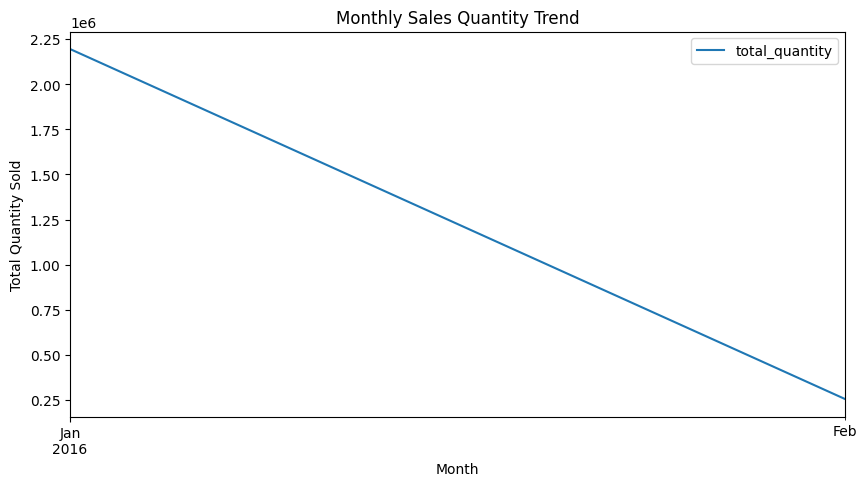

In [9]:
# 9
monthly_sales.plot(title="Monthly Sales Quantity Trend")
plt.xlabel("Month")
plt.ylabel("Total Quantity Sold")
plt.show()


### Monthly Demand Trend

Monthly sales quantities were aggregated to observe overall demand trends.
This view supports high-level demand analysis and forms the input for basic forecasting.

In [10]:
# 10
monthly_sales["moving_avg_3"] = (
    monthly_sales["total_quantity"]
    .rolling(window=3)
    .mean()
)

monthly_sales.tail()


,total_quantity,moving_avg_3
SalesDate,,
2016-01-31,2194959,NaN
2016-02-29,256210,NaN


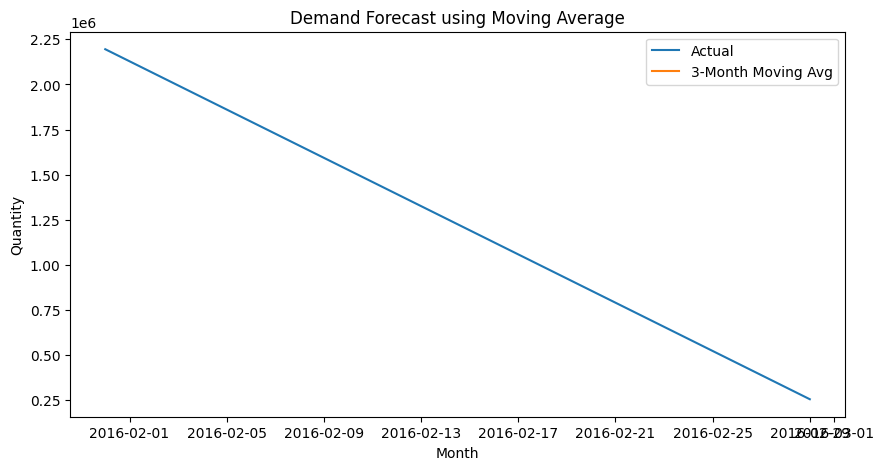

In [11]:
# 11
plt.plot(monthly_sales.index, monthly_sales["total_quantity"], label="Actual")
plt.plot(monthly_sales.index, monthly_sales["moving_avg_3"], label="3-Month Moving Avg")

plt.legend()
plt.title("Demand Forecast using Moving Average")
plt.xlabel("Month")
plt.ylabel("Quantity")
plt.show()


### Demand Forecasting Approach

A simple 3-month moving average was used to smooth demand trends.
This approach is easy to interpret and suitable for short time-series data.

In [12]:
# 12
# Assumptions
ordering_cost = 50      # cost per order
holding_cost = 2        # cost per unit per year

annual_demand = product_sales["total_quantity"].sum()

EOQ = np.sqrt((2 * annual_demand * ordering_cost) / holding_cost)
EOQ


np.float64(11070.61199753654)

### Economic Order Quantity (EOQ)

EOQ was calculated using standard assumptions for ordering and holding costs.
This provides a baseline estimate for optimal replenishment quantity
to minimize total inventory-related costs.

In [13]:
# 13
final_output = product_sales[
    ["Brand", "Description", "total_quantity", "total_revenue", "ABC_Class"]
].head(20)

final_output


,Brand,Description,total_quantity,total_revenue,ABC_Class
1655,4261,Capt Morgan Spiced Rum,20226,444810.74,A
1309,3545,Ketel One Vodka,11883,357759.17,A
440,1233,Jack Daniels No 7 Black,9578,344712.22,A
2520,8068,Absolut 80 Proof,11189,288135.11,A
1237,3405,Tito's Handmade Vodka,9203,275162.97,A
1485,3858,Grey Goose Vodka,9378,225014.22,A
826,2589,Jameson Irish Whiskey,4649,191669.51,A
1635,4227,Bacardi Superior Rum Trav,10209,183659.91,A
489,1376,Jim Beam,7362,169922.38,A
823,2585,Jameson Irish Whiskey,6940,164426.60,A


### Key Business Insights

- A small percentage of products (Class A) contributes the majority of total revenue.
- Demand data shows high concentration within a limited time period.
- Inventory planning and forecasting should prioritize Class A products.

These insights can help optimize inventory decisions and reduce operational costs.
